**Politecnico di Torino**

**01TXFSM - Machine learning and Deep learning**

**Homework 3**

**Alberto Maria Falletta - s277971**


**Install requirements**

In [1]:
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ParameterGrid
import math

**AlexNet with domain Adaptation**

In [0]:
from torch.hub import load_state_dict_from_url
from torch.autograd import Function

__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.domain_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )

    def forward(self, x, alpha):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        reverse_feature = ReverseLayerF.apply(x, alpha)
        class_output = self.classifier(x)
        domain_output = self.domain_classifier(reverse_feature)

        # if alpha is None:
        #     x = self.classifier(x)
        # else:
        #     x = ReverseLayerF.apply(x, alpha)
        #     x = self.domain_classifier(x)

        # return x
        return class_output, domain_output


def alexnet_with_dann(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'], progress=progress)
        model.load_state_dict(state_dict, strict=False)

        # Copying pretrained weights and biases to the new branch
        model.domain_classifier[1].weight.data = model.classifier[1].weight.data
        model.domain_classifier[1].bias.data = model.classifier[1].bias.data
        model.domain_classifier[4].weight.data = model.classifier[4].weight.data
        model.domain_classifier[4].bias.data = model.classifier[4].bias.data

    return model


**Functions**

In [0]:
def get_key(in_dict, in_value):
  """
  This function accepts an integer value and returns
  the string associated to the class name relating 
  to the integer, using the class_to_idx dictionary.
  """

  for key, value in in_dict.items():
    if in_value == value: 
      return key 
  return "Key not found!"


def print_occurrences(in_dataset, filename, save=False):
  """
  This function prints horizontal bar-graphs
  of occurrences of dataset's images.
  Uses get_key to decode the class name
  from its integer value.
  """

  in_occurrence_dict = {}
  # in_dataset is an object of Pacs class, therefore using .sample 
  # a list of images and labels is return.
  # These lines build a dictionary from in_dataset with labels as key and number
  # of occurrences as value
  for index in range(0, len(in_dataset)):
    img_data, img_label = in_dataset.samples[index]
    if img_label not in in_occurrence_dict:
      in_occurrence_dict[img_label] = 1
    else:
      in_occurrence_dict[img_label] += 1

  in_y = []
  in_x = []

  for key in in_occurrence_dict:
    in_y.append(get_key(in_dataset.class_to_idx, key))
    in_x.append(in_occurrence_dict[key])

  # Plot
  fig, ax = plt.subplots(figsize=(9, 5))
  ax.barh(in_y, in_x, align='center', alpha=0.5)
  ax.set_xlabel('Number of images')
  ax.set_ylabel('Classes')
  ax.set_title(filename)
  for i, v in enumerate(in_x):
    plt.text(v+0.2, i, str(v), color='steelblue', va="center")
  if save:
    plt.savefig(filename + '.png')
  plt.show()

  return


def print_accuracy_loss_plot(in_loss_list, in_accuracy_list, filename):
  """
  This function prints line plots for test accuracy and loss
  for each epoch
  """
  in_epochs = [*range(0, len(in_loss_list))]
  in_fig, in_ax = plt.subplots(1, 2, figsize=(14, 7))
  in_ax[0].plot(in_epochs, in_loss_list, c='blue', label='Loss')
  in_ax[1].plot(in_epochs, in_accuracy_list, c='green', label='Test Accuracy')
  in_ax[0].set_xlabel('Epochs')
  in_ax[1].set_xlabel('Epochs')
  in_ax[0].set_ylabel('Loss')
  in_ax[1].set_ylabel('Test Accuracy')
  plt.savefig(filename + '.png')
  plt.show()
  return

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 35      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 30       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # https://github.com/pytorch/examples/blob/master/imagenet/main.py
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                 
])

**Prepare Dataset**

In [0]:
# In case of need
if os.path.isdir('./PACS'):
  !rm -rf PACS

In [0]:
# Clone github repository with data
if not os.path.isdir('./PACS'):
  !git clone https://github.com/albeffe/Homework3-PACS
  !mv 'Homework3-PACS' 'PACS'

DATA_DIR = 'PACS/PACS'
from my_folder.my_pacs_dataset import Pacs

# Prepare Pytorch train/test Datasets
art_dataset = Pacs(os.path.join(DATA_DIR, "art_painting"), transform=train_transform)
cartoon_dataset = Pacs(os.path.join(DATA_DIR, "cartoon"), transform=train_transform)
photo_dataset = Pacs(os.path.join(DATA_DIR, "photo"), transform=train_transform)
sketch_dataset = Pacs(os.path.join(DATA_DIR, "sketch"), transform=train_transform)

# For visualization purposes
visualization_flag = False
if visualization_flag:
  print('Art Painting Dataset Items: {}'.format(len(art_dataset)))
  print('Cartoon Dataset Items: {}'.format(len(cartoon_dataset)))
  print('Photo Dataset Items: {}'.format(len(photo_dataset)))
  print('Sketch Dataset Items: {}'.format(len(sketch_dataset)))

  print_occurrences(art_dataset, 'Art Painting Dataset', True)
  print_occurrences(cartoon_dataset, 'Cartoon Dataset', True)
  print_occurrences(photo_dataset, 'Photo Dataset', True)
  print_occurrences(sketch_dataset, 'Sketch Dataset', True)

**Prepare Dataloaders**

In [0]:
# Training
source_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

# Evaluation
test_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Training**

In [11]:
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


**Train without DANN**

Starting epoch 1/30, LR = [0.001]
Step 0, Loss 2.349184274673462
Test Accuracy 0.37255859375

Starting epoch 2/30, LR = [0.001]
Step 10, Loss 0.31603628396987915
Test Accuracy 0.44580078125

Starting epoch 3/30, LR = [0.001]
Test Accuracy 0.43310546875

Starting epoch 4/30, LR = [0.001]
Step 20, Loss 0.14002126455307007
Test Accuracy 0.4375

Starting epoch 5/30, LR = [0.001]
Test Accuracy 0.4404296875

Starting epoch 6/30, LR = [0.001]
Step 30, Loss 0.13388288021087646
Test Accuracy 0.455078125

Starting epoch 7/30, LR = [0.001]
Step 40, Loss 0.052623867988586426
Test Accuracy 0.46435546875

Starting epoch 8/30, LR = [0.001]
Test Accuracy 0.46435546875

Starting epoch 9/30, LR = [0.001]
Step 50, Loss 0.05879181623458862
Test Accuracy 0.47119140625

Starting epoch 10/30, LR = [0.001]
Test Accuracy 0.48779296875

Starting epoch 11/30, LR = [0.001]
Step 60, Loss 0.03461284935474396
Test Accuracy 0.48681640625

Starting epoch 12/30, LR = [0.001]
Step 70, Loss 0.04049750417470932
Test Accur

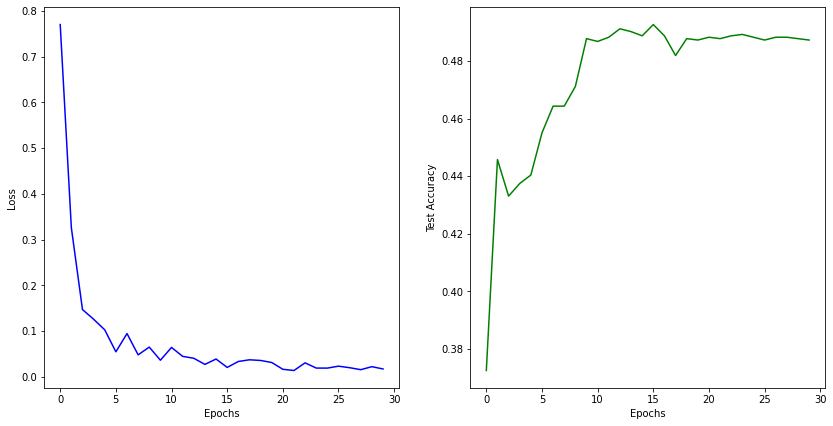

In [0]:
net = net.to(DEVICE)

cudnn.benchmark 

current_step = 0
loss_list = []
test_accuracy_list = []

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in source_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 

  loss_list.append(loss.item())

  # Test 
  net.train(False) # Set Network to evaluation mode
  test_running_corrects = 0
  for images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    test_outputs = net(images)

    # Get predictions
    _, test_preds = torch.max(test_outputs.data, 1)

    # Update Corrects
    test_running_corrects += torch.sum(test_preds == labels.data).data.item()

  # Calculate Accuracy
  test_accuracy = test_running_corrects / float(len(art_dataset))
  print('Test Accuracy {}'.format(test_accuracy))
  print()
  
  test_accuracy_list.append(test_accuracy)

print_accuracy_loss_plot(loss_list, test_accuracy_list, "Training without DANN")

**Test without DANN**

In [0]:
net = net.to(DEVICE)
net.train(False)

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

Test Accuracy: 0.4873046875


**Training with DANN**

In [0]:
net = alexnet_with_dann(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
net = net.to(DEVICE)
cudnn.benchmark

current_step = 0
loss_list = []
test_accuracy_list = []

# Static adaptation factor
alpha = 0.2

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  train_running_corrects = 0

  len_dataloader = min(len(source_dataloader), len(target_dataloader))
  data_source_iter = iter(source_dataloader)
  data_target_iter = iter(target_dataloader)
  i = 0

  while i < len_dataloader:

    # Dynamic adaptation factor # 1
    p = float(epoch) / NUM_EPOCHS / len_dataloader
    alpha = 2. / (1. + np.exp(-10 * p)) - 1

    # Dynamic adaptation factor # 2
    # alpha = (1/NUM_EPOCHS) * (epoch)

    # Dynamic adaptation factor # 3
    # alpha = (1/NUM_EPOCHS) * (epoch)
    # if alpha > 0.5:
    #  alpha = 0.5



    # Training on source data
    data_source = data_source_iter.next()

    images = data_source[0].to(DEVICE)
    class_label = data_source[1].to(DEVICE)
    domain_label = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE)

    net.train()
    optimizer.zero_grad()

    class_output, domain_output = net(images, alpha)
    loss_s_label = criterion(class_output, class_label)
    loss_s_domain = criterion(domain_output, domain_label)
    
    # Training on target data
    data_target = data_target_iter.next()
    
    images = data_target[0].to(DEVICE)
    domain_label = torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE)

    _, domain_output = net(images, alpha)
    loss_t_domain = criterion(domain_output, domain_label)
    loss = loss_t_domain + loss_s_domain + loss_s_label

    loss.backward()
    optimizer.step()
    i += 1

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}, Alpha {}'.format(current_step, loss.item(), alpha))

    current_step += 1

  # Step the scheduler
  scheduler.step()

  loss_list.append(loss_s_label.item())

  # Test 
  net.train(False)
  test_running_corrects = 0
  for images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    test_outputs, _ = net(images, alpha)

    # Get predictions
    _, test_preds = torch.max(test_outputs.data, 1)

    # Update Corrects
    test_running_corrects += torch.sum(test_preds == labels.data).data.item()

  # Calculate Accuracy
  test_accuracy = test_running_corrects / float(len(art_dataset))
  print('Test Accuracy {}'.format(test_accuracy))
  print()

  test_accuracy_list.append(test_accuracy)

print_accuracy_loss_plot(loss_list, test_accuracy_list, "Training with DANN")

Starting epoch 1/35, LR = [0.001]
Step 0, Loss 3.5017642974853516, Alpha 0.0
Step 10, Loss 0.769342303276062, Alpha 0.0
Test Accuracy 0.49462890625

Starting epoch 2/35, LR = [0.001]
Step 20, Loss 0.44245582818984985, Alpha 0.010988568672052113
Test Accuracy 0.47509765625

Starting epoch 3/35, LR = [0.001]
Step 30, Loss 0.2517087459564209, Alpha 0.021974483955019997
Test Accuracy 0.4873046875

Starting epoch 4/35, LR = [0.001]
Step 40, Loss 0.18618939816951752, Alpha 0.03295509502203586
Step 50, Loss 0.3047999143600464, Alpha 0.03295509502203586
Test Accuracy 0.4990234375

Starting epoch 5/35, LR = [0.001]
Step 60, Loss 0.1682405173778534, Alpha 0.04392775616541034
Test Accuracy 0.50439453125

Starting epoch 6/35, LR = [0.001]
Step 70, Loss 0.24104471504688263, Alpha 0.05488982934309927
Test Accuracy 0.49658203125

Starting epoch 7/35, LR = [0.001]
Step 80, Loss 0.19707730412483215, Alpha 0.06583868670947934


**Test with DANN**

In [0]:
net = net.to(DEVICE)
net.train(False)

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs, _ = net(images, alpha)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:05<00:00,  1.34it/s]

Test Accuracy: 0.50830078125


**GRID SEARCH Photo to Cartoon and Photo to Sketch without DANN**

In [0]:
hyp_parameters = {
  "batch_size": [256, 512],
  "lr": [0.01, 0.001],
  "step": [20, 30],
  "num_epochs": [40]
  }

max_valid_accuracy = 0
avg_accuracy = 0
best_config = {}
number_of_configurations = 2 * 2 * 2
current_config = 0

for config in ParameterGrid(hyp_parameters):
  
  photo_dataloader = DataLoader(photo_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, drop_last=True)
  cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)
  sketch_dataloader = DataLoader(sketch_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

  net = alexnet(pretrained=True)
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=config['lr'], momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=GAMMA)

  net = net.to(DEVICE)
  cudnn.benchmark 

  current_step = 0
  nan_flag = False
  current_config += 1

  for epoch in range(config['num_epochs']):
    print('Starting epoch {}/{}'.format(epoch+1, config['num_epochs']))

    # Photo Training -----------------------------------------------------------
    for images, labels in photo_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train()
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      if math.isnan(loss):
        nan_flag = True

      # if current_step % LOG_FREQUENCY == 0:
        # print('Step {}, Loss {}'.format(current_step, loss.item()))

      loss.backward()
      optimizer.step()
      current_step += 1

    if nan_flag:
      print()
      break

    scheduler.step() 

    # Cartoon Validation -------------------------------------------------------
    net.train(False)
    cartoon_running_corrects = 0
    for images, labels in cartoon_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      cartoon_outputs = net(images)

      # Get predictions
      _, cartoon_preds = torch.max(cartoon_outputs.data, 1)

      # Update Corrects
      cartoon_running_corrects += torch.sum(cartoon_preds == labels.data).data.item()

    # Calculate Accuracy
    cartoon_accuracy = cartoon_running_corrects / float(len(cartoon_dataset))

    # Sketch Validation --------------------------------------------------------
    net.train(False)
    sketch_running_corrects = 0
    for images, labels in sketch_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      sketch_outputs = net(images)

      # Get predictions
      _, sketch_preds = torch.max(sketch_outputs.data, 1)

      # Update Corrects
      sketch_running_corrects += torch.sum(sketch_preds == labels.data).data.item()

    # Calculate Accuracy
    sketch_accuracy = sketch_running_corrects / float(len(sketch_dataset))

    # Best Configuration -------------------------------------------------------
    avg_accuracy = (sketch_accuracy + cartoon_accuracy) / 2
    if avg_accuracy > max_valid_accuracy:
      max_valid_accuracy = avg_accuracy
      best_config = config

  print(avg_accuracy, config)

print(f"Max Accuracy = {max_valid_accuracy}")
print(f"Achieved with configuration: {best_config}")

# Max Accuracy = 0.32892334022760655
# Achieved with configuration: {'batch_size': 512, 'lr': 0.01, 'num_epochs': 35, 'step': 30}

Starting epoch 1/40
Starting epoch 2/40
Starting epoch 3/40
Starting epoch 4/40
Starting epoch 5/40
Starting epoch 6/40
Starting epoch 7/40
Starting epoch 8/40
Starting epoch 9/40
Starting epoch 10/40
Starting epoch 11/40
Starting epoch 12/40
Starting epoch 13/40
Starting epoch 14/40
Starting epoch 15/40
Starting epoch 16/40
Starting epoch 17/40
Starting epoch 18/40
Starting epoch 19/40
Starting epoch 20/40
Starting epoch 21/40
Starting epoch 22/40
Starting epoch 23/40
Starting epoch 24/40
Starting epoch 25/40
Starting epoch 26/40
Starting epoch 27/40
Starting epoch 28/40
Starting epoch 29/40
Starting epoch 30/40
Starting epoch 31/40
Starting epoch 32/40
Starting epoch 33/40
Starting epoch 34/40
Starting epoch 35/40
Starting epoch 36/40
Starting epoch 37/40
Starting epoch 38/40
Starting epoch 39/40
Starting epoch 40/40
0.26125426403995144 {'batch_size': 256, 'lr': 0.01, 'num_epochs': 40, 'step': 20}
Starting epoch 1/40
Starting epoch 2/40
Starting epoch 3/40
Starting epoch 4/40
Startin

**3A with best config**

Starting epoch 1/35, LR = [0.01]
Step 0, Loss 2.266611099243164
Test Accuracy 0.49853515625

Starting epoch 2/35, LR = [0.01]
Test Accuracy 0.43115234375

Starting epoch 3/35, LR = [0.01]
Test Accuracy 0.4462890625

Starting epoch 4/35, LR = [0.01]
Step 10, Loss 0.10215890407562256
Test Accuracy 0.478515625

Starting epoch 5/35, LR = [0.01]
Test Accuracy 0.49169921875

Starting epoch 6/35, LR = [0.01]
Test Accuracy 0.50390625

Starting epoch 7/35, LR = [0.01]
Step 20, Loss 0.03217684477567673
Test Accuracy 0.49169921875

Starting epoch 8/35, LR = [0.01]
Test Accuracy 0.45166015625

Starting epoch 9/35, LR = [0.01]
Test Accuracy 0.43896484375

Starting epoch 10/35, LR = [0.01]
Test Accuracy 0.44482421875

Starting epoch 11/35, LR = [0.01]
Step 30, Loss 0.009988056495785713
Test Accuracy 0.46435546875

Starting epoch 12/35, LR = [0.01]
Test Accuracy 0.4794921875

Starting epoch 13/35, LR = [0.01]
Test Accuracy 0.48095703125

Starting epoch 14/35, LR = [0.01]
Step 40, Loss 0.0032213376834

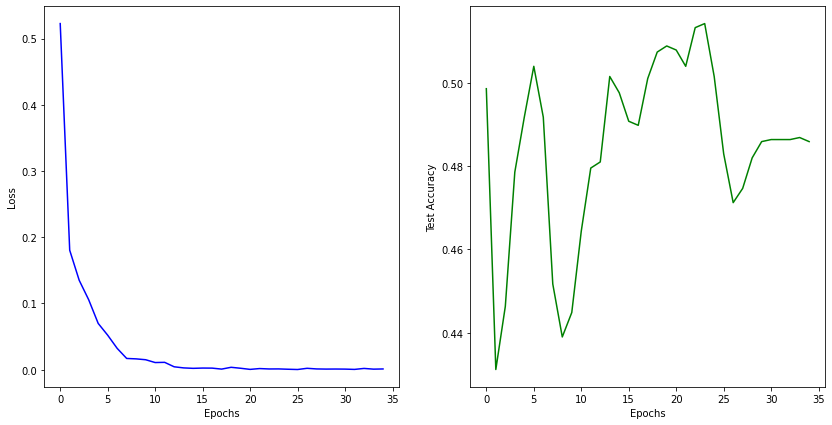

In [0]:
# To avoid re-run of previous code cell
# Max Accuracy = 0.32892334022760655
best_config = {'batch_size': 512, 'lr': 0.01, 'num_epochs': 35, 'step': 30}

source_dataloader = DataLoader(photo_dataset, batch_size=best_config["batch_size"], shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(art_dataset, batch_size=best_config["batch_size"], shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(art_dataset, batch_size=best_config["batch_size"], shuffle=False, num_workers=4)

net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=best_config["lr"], momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=best_config["step"], gamma=GAMMA)

net = net.to(DEVICE)

cudnn.benchmark 

current_step = 0
loss_list = []
test_accuracy_list = []

for epoch in range(best_config["num_epochs"]):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, best_config["num_epochs"], scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in source_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 

  loss_list.append(loss.item())

  # Test 
  net.train(False) # Set Network to evaluation mode
  test_running_corrects = 0
  for images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    test_outputs = net(images)

    # Get predictions
    _, test_preds = torch.max(test_outputs.data, 1)

    # Update Corrects
    test_running_corrects += torch.sum(test_preds == labels.data).data.item()

  # Calculate Accuracy
  test_accuracy = test_running_corrects / float(len(art_dataset))
  print('Test Accuracy {}'.format(test_accuracy))
  print()
  
  test_accuracy_list.append(test_accuracy)

print_accuracy_loss_plot(loss_list, test_accuracy_list, "Best Configuration training without DANN")

**GRID SEARCH Photo to Cartoon and Photo to Sketch with DANN**

In [0]:
hyp_parameters = {
  "batch_size": [128, 256],
  "lr": [0.01, 0.001],
  "step": [20, 30],
  "num_epochs": [40]
  }

# with batch_size 512 cuda goes out of memory

max_valid_accuracy = 0
avg_accuracy = 0
best_config = {}
number_of_configurations = 2 * 2 * 2
alpha = 0.15
current_config = 0

for config in ParameterGrid(hyp_parameters):
  
  photo_dataloader = DataLoader(photo_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, drop_last=True)
  cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)
  sketch_dataloader = DataLoader(sketch_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

  net = alexnet_with_dann(pretrained=True)
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=config['lr'], momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=GAMMA)

  net = net.to(DEVICE)
  cudnn.benchmark 

  current_step = 0
  nan_flag = False
  current_config += 1

  for epoch in range(config['num_epochs']):
    print('Starting epoch {}/{}'.format(epoch+1, config['num_epochs']))

    # Iterate over the dataset
    train_running_corrects = 0

    len_dataloader = min(len(photo_dataloader), len(cartoon_dataloader))
    data_source_iter = iter(photo_dataloader)
    data_target_iter = iter(cartoon_dataloader)
    i = 0

    while i < len_dataloader:

      # Dynamic adaptation factor
      # p = float(epoch) / NUM_EPOCHS / len_dataloader
      # alpha = 2. / (1. + np.exp(-10 * p)) - 1
      # print(f"p = {p}, Alpha = {alpha}")
      # alpha = (1/NUM_EPOCHS) * (epoch)
      # print(f"Alpha = {alpha}")

      # Training on source data
      data_source = data_source_iter.next()

      images = data_source[0].to(DEVICE)
      class_label = data_source[1].to(DEVICE)
      domain_label = torch.zeros(config['batch_size'], dtype=torch.long).to(DEVICE)

      net.train()
      optimizer.zero_grad()

      class_output, domain_output = net(images, alpha)
      loss_s_label = criterion(class_output, class_label)
      loss_s_domain = criterion(domain_output, domain_label)
    
      # Training on target data
      data_target = data_target_iter.next()
    
      images = data_target[0].to(DEVICE)
      domain_label = torch.ones(config['batch_size'], dtype=torch.long).to(DEVICE)

      _, domain_output = net(images, alpha)
      loss_t_domain = criterion(domain_output, domain_label)
      loss = loss_t_domain + loss_s_domain + loss_s_label

      loss.backward()
      optimizer.step()
      i += 1

      # Log loss
      # if current_step % LOG_FREQUENCY == 0:
      #   print('Step {}, Loss {}'.format(current_step, loss.item()))

      current_step += 1

    # Step the scheduler
    scheduler.step()

    # Cartoon Validation
    net.train(False)
    cartoon_running_corrects = 0
    for images, labels in cartoon_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      cartoon_outputs, _ = net(images, alpha)

      # Get predictions
      _, cartoon_preds = torch.max(cartoon_outputs.data, 1)

      # Update Corrects
      cartoon_running_corrects += torch.sum(cartoon_preds == labels.data).data.item()

    # Calculate Accuracy
    cartoon_accuracy = cartoon_running_corrects / float(len(art_dataset))

    # --------------------------------------------------------------------------

    # Iterate over the dataset
    train_running_corrects = 0

    len_dataloader = min(len(photo_dataloader), len(sketch_dataloader))
    data_source_iter = iter(photo_dataloader)
    data_target_iter = iter(sketch_dataloader)
    i = 0

    while i < len_dataloader:

      # Dynamic adaptation factor
      # p = float(epoch) / NUM_EPOCHS / len_dataloader
      # alpha = 2. / (1. + np.exp(-10 * p)) - 1
      # print(f"p = {p}, Alpha = {alpha}")
      # alpha = (1/NUM_EPOCHS) * (epoch)
      # print(f"Alpha = {alpha}")

      # Training on source data
      data_source = data_source_iter.next()

      images = data_source[0].to(DEVICE)
      class_label = data_source[1].to(DEVICE)
      domain_label = torch.zeros(config['batch_size'], dtype=torch.long).to(DEVICE)

      net.train()
      optimizer.zero_grad()

      class_output, domain_output = net(images, alpha)
      loss_s_label = criterion(class_output, class_label)
      loss_s_domain = criterion(domain_output, domain_label)
    
      # Training on target data
      data_target = data_target_iter.next()
    
      images = data_target[0].to(DEVICE)
      domain_label = torch.ones(config['batch_size'], dtype=torch.long).to(DEVICE)

      _, domain_output = net(images, alpha)
      loss_t_domain = criterion(domain_output, domain_label)
      loss = loss_t_domain + loss_s_domain + loss_s_label

      loss.backward()
      optimizer.step()
      i += 1

      # Log loss
      # if current_step % LOG_FREQUENCY == 0:
      #   print('Step {}, Loss {}'.format(current_step, loss.item()))

      current_step += 1

    # Step the scheduler
    scheduler.step()

    # Sketch Validation 
    net.train(False)
    sketch_running_corrects = 0
    for images, labels in sketch_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      sketch_outputs, _ = net(images, alpha)

      # Get predictions
      _, sketch_preds = torch.max(sketch_outputs.data, 1)

      # Update Corrects
      sketch_running_corrects += torch.sum(sketch_preds == labels.data).data.item()

    # Calculate Accuracy
    sketch_accuracy = sketch_running_corrects / float(len(art_dataset))
    
    # Best Configuration -------------------------------------------------------
    avg_accuracy = (sketch_accuracy + cartoon_accuracy) / 2
    if avg_accuracy > max_valid_accuracy:
      max_valid_accuracy = avg_accuracy
      best_config = config

  print(avg_accuracy, config)

print(f"Max Accuracy = {max_valid_accuracy}")
print(f"Achieved with configuration: {best_config}")

# Max Accuracy = 
# Achieved with configuration: {'batch_size': 512, 'lr': 0.01, 'num_epochs': 35, 'step': 30}

Starting epoch 1/40
Starting epoch 2/40
Starting epoch 3/40
Starting epoch 4/40
Starting epoch 5/40
Starting epoch 6/40
Starting epoch 7/40
Starting epoch 8/40
Starting epoch 9/40
Starting epoch 10/40
Starting epoch 11/40
Starting epoch 12/40
Starting epoch 13/40
Starting epoch 14/40
Starting epoch 15/40
Starting epoch 16/40
Starting epoch 17/40
Starting epoch 18/40
Starting epoch 19/40
Starting epoch 20/40
Starting epoch 21/40
Starting epoch 22/40
Starting epoch 23/40
Starting epoch 24/40
Starting epoch 25/40
Starting epoch 26/40
Starting epoch 27/40
Starting epoch 28/40
Starting epoch 29/40
Starting epoch 30/40
Starting epoch 31/40
Starting epoch 32/40
Starting epoch 33/40
Starting epoch 34/40
Starting epoch 35/40
Starting epoch 36/40
Starting epoch 37/40
Starting epoch 38/40
Starting epoch 39/40
Starting epoch 40/40
0.283447265625 {'batch_size': 128, 'lr': 0.01, 'num_epochs': 40, 'step': 20}
Starting epoch 1/40
Starting epoch 2/40
Starting epoch 3/40
Starting epoch 4/40
Starting epo

**3B with best config**

In [0]:
# To avoid re-run of previous code cell
# Max Accuracy = 0.7275390625
best_config = {'batch_size': 128, 'lr': 0.001, 'num_epochs': 35, 'step': 30}

source_dataloader = DataLoader(photo_dataset, batch_size=best_config["batch_size"], shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(art_dataset, batch_size=best_config["batch_size"], shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(art_dataset, batch_size=best_config["batch_size"], shuffle=False, num_workers=4)

net = alexnet_with_dann(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=best_config["lr"], momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=best_config["step"], gamma=GAMMA)

net = net.to(DEVICE)
cudnn.benchmark

current_step = 0
loss_list1 = []
loss_list2 = []
loss_list3 = []
loss_list4 = []
test_accuracy_list = []

# Static adaptation factor
alpha = 0.2

# Start iterating over the epochs
for epoch in range(best_config["num_epochs"]):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, best_config["num_epochs"], scheduler.get_lr()))

  # Iterate over the dataset
  train_running_corrects = 0

  len_dataloader = min(len(source_dataloader), len(target_dataloader))
  data_source_iter = iter(source_dataloader)
  data_target_iter = iter(target_dataloader)
  i = 0

  while i < len_dataloader:

    loss2 = 0
    loss3 = 0
    loss4 = 0
    cnt = 0

    # Dynamic adaptation factor
    # p = float(epoch) / NUM_EPOCHS / len_dataloader
    # alpha = 2. / (1. + np.exp(-10 * p)) - 1
    # print(f"p = {p}, Alpha = {alpha}")
    # alpha = (1/NUM_EPOCHS) * (epoch)
    # print(f"Alpha = {alpha}")

    # Training on source data
    data_source = data_source_iter.next()

    images = data_source[0].to(DEVICE)
    class_label = data_source[1].to(DEVICE)
    domain_label = torch.zeros(best_config["batch_size"], dtype=torch.long).to(DEVICE)

    net.train()
    optimizer.zero_grad()

    class_output, domain_output = net(images, alpha)
    loss_s_label = criterion(class_output, class_label)
    loss_s_domain = criterion(domain_output, domain_label)

    loss2 = loss2 + loss_s_label.item()
    loss3 = loss3 + loss_s_domain.item()
    
    # Training on target data
    data_target = data_target_iter.next()
    
    images = data_target[0].to(DEVICE)
    domain_label = torch.ones(best_config["batch_size"], dtype=torch.long).to(DEVICE)

    _, domain_output = net(images, alpha)
    loss_t_domain = criterion(domain_output, domain_label)

    loss4 = loss4 + loss_t_domain.item()

    loss = loss_t_domain + loss_s_domain + loss_s_label

    loss.backward()
    optimizer.step()
    i += 1

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss_s_label.item()))

    current_step += 1

  # Step the scheduler
  scheduler.step()

  cnt += 1
  loss_list1.append(loss_s_label.item())
  loss_list2.append(loss2/cnt)
  loss_list3.append(loss3/cnt)
  loss_list4.append(loss4/cnt)

  # Test 
  net.train(False)
  test_running_corrects = 0
  for images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    test_outputs, _ = net(images, alpha)

    # Get predictions
    _, test_preds = torch.max(test_outputs.data, 1)

    # Update Corrects
    test_running_corrects += torch.sum(test_preds == labels.data).data.item()

  # Calculate Accuracy
  test_accuracy = test_running_corrects / float(len(art_dataset))
  print('Test Accuracy {}'.format(test_accuracy))
  print()

  test_accuracy_list.append(test_accuracy)

print_accuracy_loss_plot(loss_list1, test_accuracy_list, "Best Configuration training with DANN")

**Losses plot**

In [0]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(loss_list2, c='blue', label='Source Classifier Loss')
ax.plot(loss_list3, c='orange', label='Source Domain Loss')
ax.plot(loss_list4, c='red', label='Target Domain Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend(loc="upper left")
plt.savefig("loss_plot.png")
plt.show()